In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
df_desc = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='descriptions')
df_factors = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='factors (excess returns)').set_index('Date')
df_portfolios = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='portfolios (excess returns)').set_index('Date')
df_rfr = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name='risk-free rate').set_index('Date')

In [5]:
df_factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


In [7]:
df_portfolios.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0076,0.0285,0.0084,0.1009,-0.0143,0.1002,0.0362,0.0323,0.0048,0.0059,...,0.0158,0.0875,0.0465,-0.0126,0.0430,-0.0283,0.0258,0.0768,0.0308,0.0669
1980-02-29,0.0105,-0.0608,-0.0966,-0.0322,-0.0569,-0.0323,-0.0521,-0.0800,-0.0555,-0.0167,...,-0.0079,-0.0541,-0.0346,-0.0639,-0.0652,-0.0854,-0.0959,-0.0347,-0.0282,-0.0274
1980-03-31,-0.2224,-0.1119,-0.0167,-0.1469,-0.0193,-0.1271,-0.0826,-0.1237,-0.0566,-0.0668,...,-0.0819,-0.1509,-0.1098,-0.0906,-0.1449,-0.0560,-0.0880,-0.2451,-0.1254,-0.1726
1980-04-30,0.0449,0.0766,0.0232,0.0321,0.0830,-0.0529,0.0783,0.0153,0.0304,0.0115,...,0.0420,-0.0103,-0.0312,0.0353,0.0542,0.0728,0.0530,0.0977,0.0447,0.0769
1980-05-31,0.0632,0.0793,0.0457,0.0863,0.0815,0.0509,0.0324,0.0886,0.0560,0.0098,...,0.0564,0.1063,0.1142,0.0877,0.1134,0.0578,0.0557,0.0915,0.0844,0.0685


In [8]:
df_rfr.head()

,RF
Date,
1980-01-31,0.0080
1980-02-29,0.0089
1980-03-31,0.0121
1980-04-30,0.0126
1980-05-31,0.0081


In [10]:
# 2.1
def calculate_univariate_performance_statistics(df, annualization_factor=1, quantile=0.05, periods=None):
    if periods is None:
        periods = [(df.index.min(), df.index.max())]
    
    summary_list = []

    for period in periods:
        start_date, end_date = period
        period_df = df.loc[start_date:end_date]
        
        summary_df = pd.DataFrame(index=period_df.columns)
        summary_df['Mean'] = period_df.mean() * annualization_factor
        summary_df['Volatility'] = period_df.std() * (annualization_factor ** 0.5)
        summary_df['Sharpe_ratio'] = summary_df['Mean'] / summary_df['Volatility']
        summary_df[f'VaR({quantile})'] = period_df.quantile(quantile, axis=0)
        
        start_year = pd.to_datetime(start_date).year
        end_year = pd.to_datetime(end_date).year
        summary_df['Period'] = f"{start_year}-{end_year}"
        
        summary_df = summary_df.reset_index().rename(columns={'index': 'Factor'}).set_index(['Period', 'Factor'])
        summary_list.append(summary_df)
    
    summary = pd.concat(summary_list)
    return summary

summary_statistics = calculate_univariate_performance_statistics(df_factors, 12)
# print(tabulate(summary_statistics, headers=summary_statistics.columns, tablefmt="heavy_grid"))
summary_statistics

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                               
1980-2024 MKT     0.086277    0.156904      0.549872  -0.073425
          SMB     0.008319    0.101873      0.081665  -0.043025
          HML     0.025809    0.109999      0.234629  -0.042100
          RMW     0.047096    0.083213      0.565962  -0.029725
          CMA     0.029537    0.073084      0.404148  -0.027725
          UMD     0.062709    0.154564      0.405714  -0.068225

In [16]:
periods = [(df_factors.index.min(), df_factors.index.max()),  (df_factors.index.min(), '2015-01-01'), ('2015-01-01', df_factors.index.max())]
summary_statistics = calculate_univariate_performance_statistics(df_factors, 12, periods=periods)
summary_statistics

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                               
1980-2024 MKT     0.086277    0.156904      0.549872  -0.073425
          SMB     0.008319    0.101873      0.081665  -0.043025
          HML     0.025809    0.109999      0.234629  -0.042100
          RMW     0.047096    0.083213      0.565962  -0.029725
          CMA     0.029537    0.073084      0.404148  -0.027725
          UMD     0.062709    0.154564      0.405714  -0.068225
1980-2015 MKT     0.077906    0.156064      0.499189  -0.072125
          SMB     0.016003    0.101142      0.158221  -0.041540
          HML     0.037869    0.102760      0.368514  -0.041710
          RMW     0.046049    0.085819      0.536579  -0.030315
          CMA     0.040017    0.069580      0.575120  -0.026650
          UMD     0.074206    0.158149      0.469215  -0.068205
2015-2024 MKT     0.116586    0.160285      0.727369  -0.077925
          SMB    -0.019500    0.104524     -0.186559  -0.044125
          HML    -0.017855    0.132709     -0.134544  -0.051625
          RMW     0.050886    0.073338      0.693862  -0.025150
          CMA    -0.008410    0.083989     -0.100137  -0.031125
          UMD     0.021083    0.140812      0.149723  -0.063275

#### 2.2

(a) 
1980-2024 (Overall Performance):

- MKT: Strong positive risk premium (8.63%), moderate volatility (15.7%), Sharpe of 0.55.
- SMB: Weak risk premium (0.83%), lower Sharpe (0.08), indicates low reward for small-cap exposure.
- HML: Modest premium (2.58%), moderate Sharpe (0.23), indicates some reward for value exposure.
- RMW: High premium (4.71%), Sharpe of 0.57, best factor performance.
- CMA: Moderate premium (2.95%), strong Sharpe (0.40), shows stability.
- UMD: Strong premium (6.27%), high volatility, Sharpe of 0.41, valuable for momentum-based strategies.


1980-2015 (Pre-2015 Performance):

- MKT: Positive risk premium (7.79%), Sharpe of 0.50.
- SMB: Slightly stronger premium (1.6%) than overall, low Sharpe (0.16).
- HML: Higher premium (3.79%) and Sharpe (0.37), reflects more consistent value performance.
- RMW: Strong premium (4.6%), Sharpe (0.54), maintains profitability.
- CMA: Best Sharpe ratio (0.58), strong premium (4%), consistent low-risk return.
- UMD: High premium (7.4%), Sharpe (0.47), valuable for momentum.

2015-2024 (Post-Case Performance):

- MKT: Increased premium (11.66%), highest Sharpe (0.73), market strength in recent years.
- SMB: Negative premium (-1.95%), negative Sharpe (-0.19), size factor underperformed.
- HML: Negative premium (-1.78%), negative Sharpe (-0.13), value factor lost appeal.
- RMW: Strong premium (5.09%), high Sharpe (0.69), remains profitable.
- CMA: Negative premium (-0.84%), negative Sharpe (-0.10), low reward for conservative investment.
- UMD: Reduced premium (2.11%), Sharpe (0.15), momentum weakened.

  
(b) Factor Performance since 2015:

- MKT and RMW have increased their Sharpe ratios and maintained strong risk-adjusted returns.
- UMD has weakened but retains a positive Sharpe ratio.
- SMB, HML, and CMA factors experienced negative returns and lower Sharpe ratios, suggesting small-cap, value, and conservative strategies underperformed post-2015, possibly due to market preference for growth and momentum-driven stocks in recent years.
- This reflects a shift in factor performance since 2015, with profitability concentrated in market-wide and quality-oriented (RMW) exposures while traditional size and value premiums have declined.








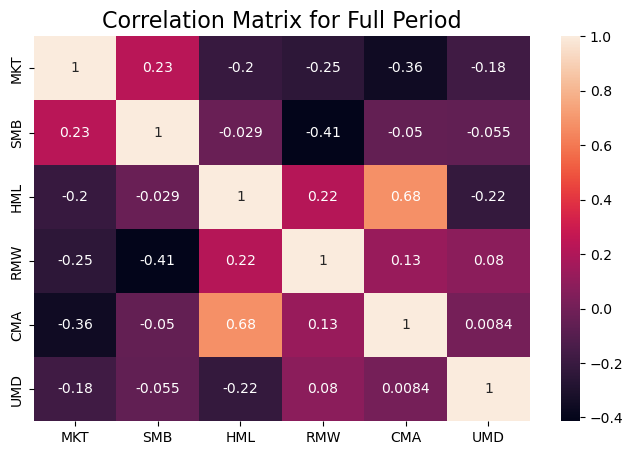

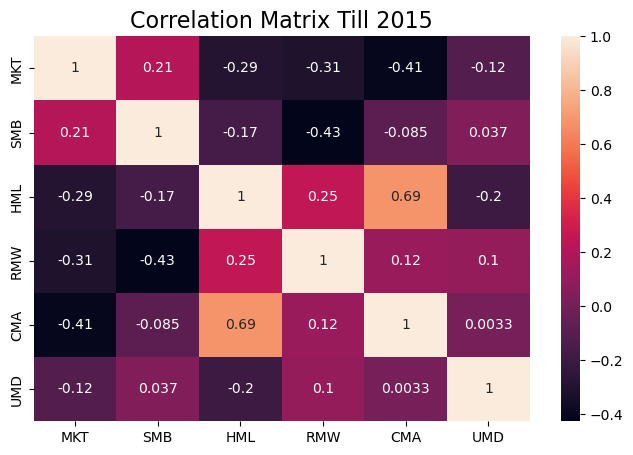

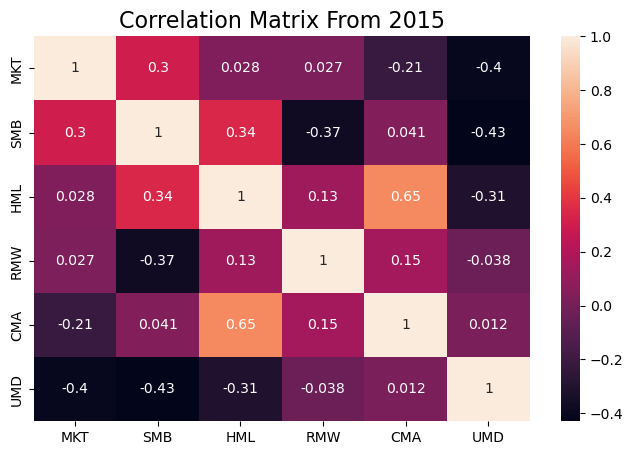

In [40]:
# 2.3
def plot_correlation_matrix(df, title=None, max_min=False):
    fig, ax = plt.subplots(figsize=(8, 5))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, 
                xticklabels=correlation_matrix.columns,
                yticklabels=correlation_matrix.columns, annot=True, ax=ax)
    if title:
        ax.set_title(title, fontsize=16)

    if max_min:
        corrs = correlation_matrix.unstack().sort_values().to_frame('Corr')
        corrs = corrs[corrs['Corr'] != 1]
        corrs_max = corrs.index[-1]
        corrs_min = corrs.index[0]
        print(f'Max Correlation pair is {corrs_max}')
        print(f'Min Correlation pair is {corrs_min}')

plot_correlation_matrix(df_factors, title="Correlation Matrix for Full Period")
plot_correlation_matrix(df_factors.loc[:'2015-01-01'], title="Correlation Matrix Till 2015")
plot_correlation_matrix(df_factors.loc['2015-01-01':], title="Correlation Matrix From 2015")

a. Correlation:
- Construction Success: Overall, the factors display low correlations, suggesting effective diversification in capturing distinct risk exposures.
- Negative correlations add unique, uncorrelated exposures to the model.
- HML and CMA exhibit a relatively high correlation (0.68), suggesting they may capture overlapping aspects of value and conservative investment.
- RMW and SMB also show a moderate negative correlation (-0.41), indicating some inverse relationship between profitability and size.


b. Redundancy of HML:

- The high correlation between HML and CMA, and moderate correlation with RMW, supports Fama and French's observation.
- HML appears to overlap with other factors, particularly CMA, which might reduce its unique contribution in the 5-factor model.
- HML could be considered somewhat redundant among the factors.

In [19]:
# 2.4
def calculate_tangency_weights(df_excess_returns, annualization_factor=12):
    mu = df_excess_returns.mean() * annualization_factor
    cov_matrix = df_excess_returns.cov() * annualization_factor
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    ones = np.ones(len(mu))
    scaling_factor = 1 / (ones.T @ inv_cov_matrix @ mu)
    tangency_weights = scaling_factor * (inv_cov_matrix @ mu)
    tangency_df = pd.DataFrame({
        'Asset': df_excess_returns.columns,
        'Weights': tangency_weights
    })
    net_benchmark = df_excess_returns @ tangency_weights
    net_benchmark_df = pd.DataFrame(index = df_excess_returns.index)
    net_benchmark_df['Tangency'] = net_benchmark
    return tangency_df, net_benchmark_df

tangency_weights, tangency_returns = calculate_tangency_weights(df_factors, annualization_factor=12)
tangency_weights

,Asset,Weights
0,MKT,0.209760
1,SMB,0.077337
2,HML,-0.042142
3,RMW,0.313263
4,CMA,0.338982
5,UMD,0.102798


Most Important Factors: RMW and CMA hold the highest weights, suggesting that profitability (RMW) and conservative investment (CMA) are critical for optimizing risk-adjusted returns.


Least Important Factor: HML has a negative weight, indicating it detracts from the portfolio's optimal performance, aligning with earlier observations on its potential redundancy.


Low Mean Return Factors: Factors like SMB (small-cap) and HML (value) still play a role, with SMB contributing positively. This suggests that even factors with lower returns can enhance the portfolio's risk-adjusted performance when appropriately weighted.

In [20]:
calculate_univariate_performance_statistics(tangency_returns, 12)

,,Mean,Volatility,Sharpe_ratio,VaR(0.05)
Period,Factor,,,,
1980-2024,Tangency,0.048865,0.039511,1.236763,-0.014274


In [23]:
tangency_weights, tangency_returns = calculate_tangency_weights(df_factors[["MKT", "SMB", "HML", "UMD"]], annualization_factor=12)
tangency_weights

,Asset,Weights
0,MKT,0.365529
1,SMB,-0.032422
2,HML,0.356199
3,UMD,0.310694


In [24]:
calculate_univariate_performance_statistics(tangency_returns, 12)

,,Mean,Volatility,Sharpe_ratio,VaR(0.05)
Period,Factor,,,,
1980-2024,Tangency,0.059943,0.066168,0.905931,-0.027645


High Weights: MKT and HML now receive the highest weights, showing that market exposure (MKT) and value (HML) gain prominence in the absence of RMW and CMA.


Low Weight: SMB has a negative weight, indicating it detracts from the tangency portfolio's efficiency without RMW and CMA.


- Removing RMW and CMA highlights the importance of MKT, HML, and UMD in optimizing returns, with HML's role becoming more pronounced, despite its earlier redundancy when all factors were considered.

In [92]:
# 3.1
import statsmodels.api as sm
import pandas as pd
import numpy as np

def factor_analysis(df_portfolios, df_market, annualization=1):
    alphas, treynor_ratios, information_ratios, r_squared, maes = [], [], [], [], []
    betas_dict = {factor: [] for factor in df_market.columns} 

    for col in df_portfolios.columns:
        y = df_portfolios[col]
        X = sm.add_constant(df_market)
        model = sm.OLS(y, X, missing='drop').fit()
        
        alpha = model.params['const'] * annualization
        
        for factor in df_market.columns:
            betas_dict[factor].append(model.params.get(factor, np.nan))
        
        mean_excess_return = y.mean()
        primary_beta = model.params[df_market.columns[0]]
        treynor_ratio = mean_excess_return * annualization / primary_beta if primary_beta != 0 else np.nan

        expected_return = alpha + sum(model.params[factor] * df_market[factor].mean() for factor in df_market.columns)
        residual_std_dev = model.resid.std()
        mae = model.resid.abs().mean()
        
        information_ratio = model.params['const'] * (annualization)**0.5 / residual_std_dev if residual_std_dev != 0 else np.nan

        alphas.append(alpha)
        treynor_ratios.append(treynor_ratio)
        information_ratios.append(information_ratio)
        r_squared.append(model.rsquared)
        maes.append(mae)

    results_df = pd.DataFrame({
        'Alpha': alphas,
        'Treynor Ratio': treynor_ratios,
        'Information Ratio': information_ratios,
        'R-Squared': r_squared,
        'MAE': mae
    }, index=df_portfolios.columns)

    for factor, beta_values in betas_dict.items():
        results_df[f'Beta_{factor}'] = beta_values
    
    return results_df

In [93]:
# 3.1.1
results_aqr = factor_analysis(df_portfolios, df_factors[["MKT", "HML", "RMW", "UMD"]], annualization=12)
results_aqr[['Alpha', 'R-Squared']]

,Alpha,R-Squared
Agric,0.007721,0.339175
Food,0.006950,0.464221
Soda,0.017230,0.308354
Beer,0.017060,0.420762
Smoke,0.035306,0.273489
Toys,-0.037334,0.508340
Fun,0.030502,0.616501
Books,-0.029420,0.686774
Hshld,-0.008089,0.558410
Clths,-0.018153,0.618299


In [94]:
# 3.1.2
mae_aqr = np.mean(np.abs(results_aqr['Alpha']))
print("\nMean Absolute Error (MAE) for AQR :", mae_aqr)


Mean Absolute Error (MAE) for AQR : 0.02299261897974791


#### 3.1.3
- If the AQR 4-Factor Model is effective, we would expect the alpha estimates to be small
- In factor models, alpha represents the portion of an asset's return not explained by the risk factors. A small or zero alpha would indicate that the model captures most of the systematic risk and there’s minimal unexplained return, meaning the model is effective.
- If the model accurate, there should be no alpha after accounting for the factors. Large alphas would imply that significant returns are left unexplained, suggesting model inefficiency.

#### 3.1.4
- An MAE of 0.02299 indicates that, on average, the alphas are close to zero, which suggests the model explains a substantial portion of the returns across different assets.
- This is a positive indicator of the model's effectiveness.
- While the MAE is low, it isn’t zero, implying that some portion of asset returns is still unexplained. 
- The low MAE supports the model’s pricing ability, but some unexplained returns suggest there may be room for improvement.

In [95]:
# 3.2
results_capm = factor_analysis(df_portfolios, df_factors[["MKT"]], annualization=12)
results_ff3 = factor_analysis(df_portfolios, df_factors[["MKT", "SMB", "HML"]], annualization=12)
results_ff5 = factor_analysis(df_portfolios, df_factors[["MKT", "SMB", "HML", "RMW", "CMA"]], annualization=12)

In [96]:
# 3.2.1
mae_capm = np.mean(np.abs(results_capm['Alpha']))
print("\nMean Absolute Error (MAE) for CAPM :", mae_capm)

mae_ff3 = np.mean(np.abs(results_ff3['Alpha']))
print("\nMean Absolute Error (MAE) for FF-3 :", mae_ff3)

mae_ff5 = np.mean(np.abs(results_ff5['Alpha']))
print("\nMean Absolute Error (MAE) for FF-5 :", mae_ff5)



Mean Absolute Error (MAE) for CAPM : 0.020401569232397478

Mean Absolute Error (MAE) for FF-3 : 0.02398380425187015

Mean Absolute Error (MAE) for FF-5 : 0.03136735845666052


#### 3.2.2

- CAPM has the lowest MAE (0.0204), it provides the best fit among these models for this particular dataset.
- CAPM shows the best fit based on MAE, followed closely by the AQR 4-Factor Model.
- The Fama-French models (both 3 and 5 factors) have higher MAE values, indicating less effective fits for this dataset.

#### 3.3

- MKT alone provides the best fit among the models based on MAE (0.0204), indicating that market exposure is a crucial factor for explaining returns. 
- This suggests that broader market risk captures a significant portion of systematic risk.
- Adding SMB and HML does not improve the fit significantly, suggesting that small-cap and value premiums may have limited additional explanatory power for this dataset.
- The addition of RMW and CMA ) worsens the fit, indicating potential redundancy or limited contribution of these factors to pricing in this dataset.
- The high MAE suggests that expanding to five factors may overcomplicate the model without adding significant predictive power.
- The inclusion of UMD improves fit over the FF-3 and FF-5 models, with an MAE (0.02299) close to CAPM. This suggests that Momentum may capture unique aspects of return that the other Fama-French factors miss.
- RMW and HML remain consistent in both the Fama-French and AQR models, indicating some importance, but UMD’s presence in AQR highlights its unique contribution.

Yes, Momentum (UMD) appears valuable. The AQR model’s performance, with UMD included, outperforms the FF-3 and FF-5 models and approaches CAPM in fit. 

In [102]:
# 3.4
r_squared = pd.DataFrame({
    'AQR': results_aqr['R-Squared'],
    'CAPM': results_capm['R-Squared'],
    'FF-3': results_ff3['R-Squared'],
    'FF5': results_ff5['R-Squared']
}, index=results_ff5.index)
r_squared

,AQR,CAPM,FF-3,FF5
Agric,0.339175,0.330534,0.357393,0.363375
Food,0.464221,0.366464,0.416709,0.490799
Soda,0.308354,0.253740,0.280459,0.313214
Beer,0.420762,0.333662,0.362360,0.442389
Smoke,0.273489,0.189975,0.236211,0.305338
Toys,0.508340,0.495417,0.528722,0.549694
Fun,0.616501,0.599294,0.609808,0.613717
Books,0.686774,0.652329,0.688783,0.702782
Hshld,0.558410,0.493945,0.513703,0.589291
Clths,0.618299,0.558941,0.574434,0.628634


In [98]:
r_squared.mean().to_frame().rename(columns={0:'R^2 Mean'})

,R^2 Mean
AQR,0.574935
CAPM,0.526107
FF-3,0.571484
FF5,0.595951


- AQR and FF-3 models lead to high R-squared statistics, supporting their use in a Linear Factor Decomposition framework for these assets.
- The CAPM also performs well for single-factor decomposition.
- FF-5’s lower R-squared suggests that the additional factors do not significantly improve the model's explanatory power and may not be as effective in linear decomposition for these assets.

In [111]:
# 3.5
cs_aqr = factor_analysis(
    df_portfolios.mean().to_frame('AQR'), 
    results_aqr[[col for col in results_aqr.columns if col.startswith('Beta_')]],
    12
)
cs_capm = factor_analysis(
    df_portfolios.mean().to_frame('CAPM'), 
    results_capm[[col for col in results_capm.columns if col.startswith('Beta_')]],
    12
)
cs_ff3 = factor_analysis(
    df_portfolios.mean().to_frame('FF3'), 
    results_ff3[[col for col in results_ff3.columns if col.startswith('Beta_')]],
    12
)
cs_ff5 = factor_analysis(
    df_portfolios.mean().to_frame('FF5'), 
    results_ff5[[col for col in results_ff5.columns if col.startswith('Beta_')]],
    12
)

In [124]:
df_factors.mean().to_frame().rename(columns={0: 'TS Risk Premia'})

,TS Risk Premia
MKT,0.007190
SMB,0.000693
HML,0.002151
RMW,0.003925
CMA,0.002461
UMD,0.005226


In [118]:
results_cs[[col for col in results_cs.columns if col.startswith('Beta_')]]

,Beta_Beta_MKT,Beta_Beta_HML,Beta_Beta_RMW,Beta_Beta_UMD,Beta_Beta_SMB,Beta_Beta_CMA
AQR,0.001931,-0.002710,0.001897,0.000892,NaN,NaN
CAPM,0.000514,NaN,NaN,NaN,NaN,NaN
FF3,0.003331,-0.001637,NaN,NaN,-0.003604,NaN
FF5,0.003904,-0.002228,0.002021,NaN,-0.003866,-0.001811


- MKT: The time-series premium for MKT is 0.007190, while the cross-sectional estimates range from around 0.000514 (CAPM) to 0.003904 (FF5). The cross-sectional MKT estimates are generally lower than the time-series average, suggesting some discrepancy between the two measures.
- HML: The time-series premium is 0.002151, whereas cross-sectional estimates vary, with values like -0.001637 (FF3) and -0.002228 (FF5). The negative values in cross-sectional results differ substantially from the time-series premium, indicating that HML may not consistently contribute positively across assets.
- Other Factors (SMB, RMW, CMA, UMD): Similar discrepancies can be observed for SMB, RMW, CMA, and UMD, where cross-sectional estimates often do not match the time-series averages closely.


In [139]:
results_cs = pd.concat([cs_aqr, cs_capm, cs_ff3, cs_ff5])
results_cs[['MAE']].rename(columns = {'MAE':'MAE CS'})

,MAE CS
AQR,0.001137
CAPM,0.001271
FF3,0.000989
FF5,0.000961


In [140]:
pd.DataFrame({'MAE TS':[mae_aqr,mae_capm, mae_ff3, mae_ff5]}, index=results_cs.index)

,MAE TS
AQR,0.022993
CAPM,0.020402
FF3,0.023984
FF5,0.031367
